# Part 2: From AnalogCore to Analog Torch Networks

In [11]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from simulator import AnalogCore
from applications.mvm_params import set_params
from tqdm import tqdm
import pandas as pd

from pathlib import Path

In [12]:
# This section just creates MNIST dataloaders for use later in the notebook
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import os

batch_size = 32
basedir = os.path.expanduser('~/mnist')
data = torchvision.datasets.MNIST(basedir, download=True, 
                                  transform=torchvision.transforms.ToTensor(),
                                  target_transform=torchvision.transforms.Compose([
                                    lambda x:torch.tensor([x]), 
                                    lambda x:F.one_hot(x,10).float(),
                                    lambda x:x.squeeze(),
                                    ]),
                                  )

ds_train, ds_val = random_split(data, [0.8, 0.2])

loader_train = DataLoader(ds_train,
                        batch_size=batch_size,
                        shuffle=True,
                        )


loader_val = DataLoader(ds_val,
                        batch_size=batch_size,
                        shuffle=False)

In [13]:
example_input, example_output = next(iter(loader_val))
example_label = example_output.argmax(axis=-1)

# 2.1: MLP in CrossSim from scratch

Recall from the previous notebook that CrossSim's `AnalogCore` class will implement matrix-vector multiplications with a variable amount of nonlinearities. All that is required is to initialize the AnalogCore object, then utilize as you would any matrix. Eg:

```python
W = torch.rand(3*28*28, 1*28*28)
params = set_params()
xbar = AnalogCore(W, params=params)

output = xbar @ x
```

This is the core structure required for a Linear layer of a neural network.
One could implement neural networks using this type of interface. As an example, a multi-layer perceptron can be coded in vanilla numpy as :

In [14]:
def relu(x):
    return x * (x > 0)
    
def sigmoid(z):
    return 1/(1 + np.exp(-z))

class mlp:
    def __init__(self,
                 n_units,
                 activation = None,
                 weights = None
                 ):
        
        if activation is None:
            activation = [relu] * len(n_units)
            activation[-1] = sigmoid
            activation = tuple(activation)
        self.activation = activation
        
        self.weights = list()
        if weights is None:
            for i in range(0, len(n_units)-1):
                w = np.random.uniform(-1/np.sqrt(n_units[i]),
                                      1/np.sqrt(n_units[i]), 
                                      size=(n_units[i+1], n_units[i]))
                self.weights.append(w)
        else:
            for i in range(0, len(n_units)-1):
                self.weights.append(weights[i])

    def forward(self, x):
        for n in range(0, len(self.weights)):
                x = self.weights[n] @ x
                x = self.activation[n](x)

        return x

To convert this to a CrossSim simulation, all we need to do is replace the weight matrices with analog core equivalents:

In [15]:
class mlp_cs:
    def __init__(self,
                 n_units,
                 xsim_params,       # <--- One additional argument
                 activation = None,
                 weights = None,
                 ):
        
        if activation is None:
            activation = [relu] * len(n_units)
            activation[-1] = sigmoid
            activation = tuple(activation)
        self.activation = activation


        self.weights = list()
        if weights is None:
            for i in range(0, len(n_units)-1):
                w = np.random.uniform(-1/np.sqrt(n_units[i]),
                                      1/np.sqrt(n_units[i]), 
                                      size=(n_units[i+1], n_units[i]))
                w = AnalogCore(w, params=xsim_params) # <--- One line-change of code!
                self.weights.append(w)
        else:
            for i in range(0, len(n_units)-1):
                w = AnalogCore(weights[i], params=xsim_params) # <--- One line-change of code!
                self.weights.append(w)


    def forward(self, x):
        for n in range(0, len(self.weights)):
                x = self.weights[n] @ x
                x = self.activation[n](x)

        return x

The mlp class takes in a tuple of sizes, the same as torch.nn.Linear, and implements the linear layers as AnalogCore multiplications. 

Similar to torch.nn.Sequential, we have implemented mlp.forward() to call each analog linear layer in series. Inference could then be run as normal. 
We can demonstrate that the CrossSim solution gives similar results as the digital implementation by running both versions with the same pre-defined weights

In [16]:
cs_params = set_params()
cs_params.xbar.device.cell_bits = 1                      # Quantized Weights
cs_params.xbar.device.programming_error.model = 'SONOS'  # Experimentally defined write errors
cs_params.xbar.device.programming_error.enable = True    # SONOS 
cs_params.simulation.convolution.conv_matmul = True      # Digital acceleration for batched convolutions.

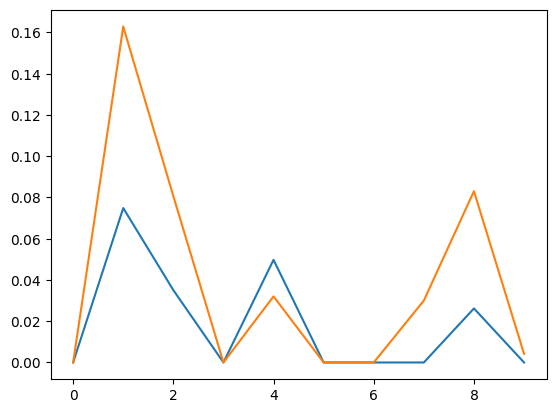

In [17]:
n_units = [1*28*28, 3*28*28, 100, 10]
weights = list()
for i in range(0, len(n_units)-1):
    w = np.random.uniform(-1/np.sqrt(n_units[i]),
                          1/np.sqrt(n_units[i]), 
                          size=(n_units[i+1], n_units[i]))
    weights.append(w)
    
net = mlp(n_units, weights=weights)
net_cs = mlp_cs(n_units, weights=weights, xsim_params=cs_params)

x = np.random.rand(1*28*28)

pred_np = net.forward(x)
pred_cs = net_cs.forward(x)

plt.plot(pred_np)
plt.plot(pred_cs)

In principle, one could re-implement all torch.nn layers using this approach. 
However, this would require manual implementations and would not enable learning. 
In the next two sections we show how to utilize pre-defined drop-in Analog replacements for a subset of layers

# 2.2: Torch --> CrossSim Conversion
Rather than implementing layers directly with AnalogCore, we can utilize the `simulator.algorithms.dnn.torch` interface to directly convert PyTorch networks, and CrossSim will convert them to AnalogCore behind the scenes.

We first define and evaluate a simple pre-trained MNIST network:

In [18]:
# Network structure and training information for all networks
n_chans = [1, 8, 16]
n_units = [28*28*16, 100, 10]
n_epochs = 20
retrain = False
# If false, will load pretrained networks and training curves, to avoid burning out laptops

We first create a random CNN, load weights from a pretrained network, and evaluate the network accuracy

In [19]:
net_pt = torch.nn.Sequential(
    torch.nn.Conv2d(n_chans[0], n_chans[1], 3, padding='same'),
    torch.nn.ReLU(),
    # ----
    torch.nn.Conv2d(n_chans[1], n_chans[2], 3, padding='same'),
    torch.nn.ReLU(),
    # ----
    torch.nn.Flatten(),
    torch.nn.Linear(n_units[0], n_units[1]),
    # ----
    torch.nn.ReLU(), 
    torch.nn.Linear(n_units[1], n_units[2]),
)

ckpt = torch.load('./logs/mnist_pt/net.pt', map_location='cpu')
net_pt.load_state_dict(ckpt['state_dict'])

pred = net_pt(example_input)
pred_label = pred.argmax(axis=-1)

loss = torch.nn.functional.cross_entropy(pred, example_output)

accuracy = (pred_label == example_label).sum() / batch_size
print(accuracy)
print(loss)

tensor(1.)
tensor(5.5879e-08, grad_fn=<DivBackward1>)


We can now convert the pretrained network into a CrossSim equivelant

In [20]:
from simulator import CrossSimParameters
from simulator.algorithms.dnn.torch.convert import from_torch, convertible_modules

cs_params = CrossSimParameters()
cs_params.xbar.device.cell_bits = 4                     # Quantized Weights
cs_params.xbar.device.programming_error.model = 'SONOS'  # Experimentally defined write errors
cs_params.xbar.device.programming_error.enable = True    # SONOS 
cs_params.simulation.convolution.conv_matmul = True      # Digital acceleration for batched convolutions.
cs_params.xbar.adc.mvm.calibrated_range = [-1,1]         # Calibrate ADC buckets based on expected values
cs_params.xbar.adc.mvm.bits = 4                          # 16-level ADC
cs_params.xbar.adc.mvm.model = 'QuantizerADC'            # Simple quantizeation

convertible_modules(net_pt)

[Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same),
 Linear(in_features=12544, out_features=100, bias=True),
 Linear(in_features=100, out_features=10, bias=True)]

The output of convertible_modules tells us which layers will be converted into their AnalogLayer equivelant

In [21]:
net_cn = from_torch(net_pt, cs_params)
print(net_cn)
# "net converted"

Sequential(
  (0): AnalogConv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): AnalogConv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): AnalogLinear(in_features=12544, out_features=100, bias=True)
  (6): ReLU()
  (7): AnalogLinear(in_features=100, out_features=10, bias=True)
)


Note that the convolutional and linear layers have been replaced with AnalogLayer equivelants. These layers will now utilize an AnalogCore, as defined by the cs_params, during inference.

In [22]:
pred = net_cn(example_input)
pred_label = pred.argmax(axis=-1)
accuracy = (pred_label == example_label).sum() / 32

loss_con = torch.nn.functional.cross_entropy(pred, example_output)

print(accuracy)
print(loss_con)

tensor(0.9375)
tensor(1.1607, grad_fn=<DivBackward1>)


There is a *post training conversion accuracy decrease* of approximately 3.2%, and corresponding loss increase of 0.86. 
While this is change in accuracy is minor, the increase in error can be substantially higher in more difficult tasks. 

In the next section we will implement CrossSim in the loop training, which trains in a hardware-aware manner to avoid these losses in performance.

# 2.3 CrossSim in the Loop Training

AnalogLayers have been designed such that the forward pass uses an AnalogCore during forward (ie: inference) pass, but provide an idealized ("pass through") and differentiable trace during the backwards pass. 
This means that, to the extent the idealized operation matches the true AnalogCore forward pass, we can perform surrogate gradient descent.
This can allow a network to adapt to these non-idealities and recover some of the performance that would be lost from post-training conversion.

![](figs/surrogate.png)

To demonstrate this functionality, we first define and train a PyTorch network:

In [23]:
class SequentialWrapper():
    def __init__(self, net, loss, learning_rate=1e-3, last_only=False):
        self.net = net
        self.loss = loss
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)

    def forward(self, x):
        out = self.net(x)
        return out
    
    def training_step(self, batch):
        self.optimizer.zero_grad()

        pred = self.forward(batch[0])
        loss = self.loss(pred, batch[1])

        loss.backward()
        self.optimizer.step()
        return loss

    def validation_step(self, batch):
        pred = self.forward(batch[0])
        loss = self.loss(pred, batch[1])
        return loss
    
    def train_epoch(self, train_loader, val_loader):
        loss_train = 0
        for minibatch in iter(train_loader):
            loss_train += self.training_step(minibatch).detach()

        loss_val = 0
        for minibatch in iter(val_loader):
            loss_val += self.validation_step(minibatch).detach()

        return loss_train/len(train_loader), loss_val/len(val_loader)
    
    def train(self, train_loader, val_loader, epochs, name):
        loss_train = np.zeros(epochs)
        loss_val = np.zeros(epochs)

        for e in tqdm(range(0, epochs)):
            lt, lv = self.train_epoch(train_loader, val_loader)
            loss_train[e] = lt
            loss_val[e] = lv

        Path('./logs/' + name).mkdir(parents=True, exist_ok=True)
        np.save('./logs/' + name + '/loss_train', loss_train)
        np.save('./logs/' + name + '/loss_val', loss_val)
        torch.save(
            {'state_dict': self.net.state_dict()},
            './logs/' + name + '/net.pt')
        
        return loss_train, loss_val

In [24]:
net_pt = torch.nn.Sequential(
    torch.nn.Conv2d(n_chans[0], n_chans[1], 3, padding='same'),
    torch.nn.ReLU(),
    # ----
    torch.nn.Conv2d(n_chans[1], n_chans[2], 3, padding='same'),
    torch.nn.ReLU(),
    # ----
    torch.nn.Flatten(),
    torch.nn.Linear(n_units[0], n_units[1]),
    # ----
    torch.nn.ReLU(), 
    torch.nn.Linear(n_units[1], n_units[2]),
)

model_pt = SequentialWrapper(net_pt, torch.nn.CrossEntropyLoss())

if retrain:
    loss_train_pt, loss_val_pt = model_pt.train(loader_train, loader_val, n_epochs,'mnist_pt')
else:
    loss_train_pt =  np.load('./logs/mnist_pt/loss_train.npy')
    loss_val_pt = np.load('./logs/mnist_pt/loss_val.npy')
    ckpt = torch.load('./logs/mnist_pt/net.pt', map_location='cpu')
    model_pt.net.load_state_dict(ckpt['state_dict'])

We can next check which layers of the network are eligible for automatic conversion to AnalogLayers

In [25]:
convertible_modules(net_pt)

[Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same),
 Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same),
 Linear(in_features=12544, out_features=100, bias=True),
 Linear(in_features=100, out_features=10, bias=True)]

Here `convertible_modules` tells us that the convolutional weights and linear weights are all able to be converted automatically. 
We can convert these using `from_torch`, passing an appropriate CrossSim parameter set.

In [26]:
# Create a new network, so that we are training from scratch
net_cs = torch.nn.Sequential(
    torch.nn.Conv2d(n_chans[0], n_chans[1], 3, padding='same'),
    torch.nn.ReLU(),
    # ----
    torch.nn.Conv2d(n_chans[1], n_chans[2], 3, padding='same'),
    torch.nn.ReLU(),
    # ----
    torch.nn.Flatten(),
    torch.nn.Linear(n_units[0], n_units[1]),
    # ----
    torch.nn.ReLU(), 
    torch.nn.Linear(n_units[1], n_units[2]),
)

net_cs = from_torch(net_cs, cs_params)

One slight change is that during training we must explicitly synchronize changes from PyTorch optimizer steps to the AnalogLayers after each optimization step, so we introduce a new wrapper class

In [27]:
from simulator.algorithms.dnn.torch.convert import synchronize

class SequentialCSWrapper(SequentialWrapper):
    def __init__(self, net, loss, learning_rate=1e-3):
        super().__init__(net, loss, learning_rate)
        
    def training_step(self, batch):
        self.optimizer.zero_grad()

        pred = self.forward(batch[0])
        loss = self.loss(pred, batch[1])

        loss.backward()
        self.optimizer.step()
        synchronize(self.net)  # <--- The only changed line in all of training!
        return loss

model_cs = SequentialCSWrapper(net_cs, torch.nn.CrossEntropyLoss())

In [28]:
if retrain:
    loss_train_cs, loss_val_cs = model_cs.train(loader_train, loader_val, n_epochs, 'mnist_cs')
else:
    loss_train_cs =  np.load('./logs/mnist_cs/loss_train.npy')
    loss_val_cs = np.load('./logs/mnist_cs/loss_val.npy')
    ckpt = torch.load('./logs/mnist_cs/net.pt', map_location='cpu')
    #model_cs.net.load_state_dict(ckpt['state_dict'])

# Evaluation:
We can now evaluate the training curves for the vanilla Pytorch network, compared to the Analog simulations:

Text(0, 0.5, 'Loss (Cross Entopy)')

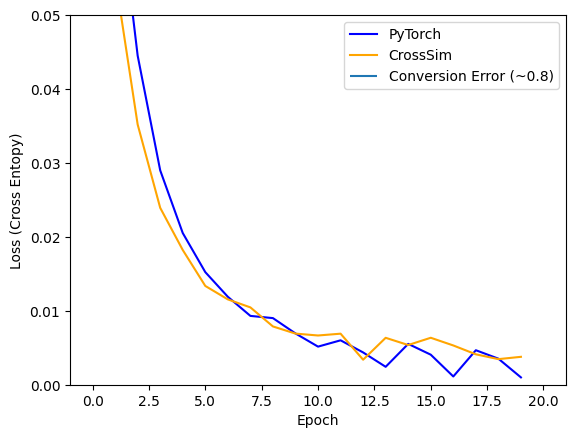

In [29]:
plt.plot(loss_train_pt,'blue')
plt.plot(loss_train_cs,'orange')
plt.ylim([0,0.05])
plt.hlines(loss_con.detach(), 0, 20)

plt.legend(['PyTorch','CrossSim','Conversion Error (~0.8)'])
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entopy)')


The final performance of both networks is similar, even though we have implemented write errors into the memristive device and utilized 8-bit quantization of activities. 

In the next notebook we will show how to use these same principles to implement analog recurrent neural networks and analog spiking networks.